# Cooriro fuel reciept reading

- This code contains two functions: preprocess_image and preprocess_image_from_url. The first takes an image and preprocess it then sends it to OpenAI to get th info, the second one sends the url of the image *(without preprocessing).

- The first one is supposed to give better results.

- accepts png, jpg and jpeg images.

- The response is a JSON that resciept info. If any of the details is not attained, it will return 'Unknown'.

- If the reciept is not accepted (even in arabic), it will give a zero

- The results are not 100% accurate, the OpenAI model can have difficulties in reading blurry images, or some Arabic numbers.

- The notebook contains some simple testing on various images.

- Cost: In average 0.005USD per image => 5USD  per 1000 images

In [24]:
import base64
import requests
import os
import json
from PIL import Image
import base64
import io

from dotenv import load_dotenv
env_path = 'C:/Users/user/Desktop/My_Files/Anaconda  Projects/DevTechPro/.env'
OPENAI_API_KEY= os.getenv("OPENAI_API_KEY")

In [25]:
#analyse_image_from_url does not contain image pre processing

In [29]:
def encode_image(image_path): 
    """Encode an image to a base64 string.""" 
    with open(image_path, "rb") as image_file: 
        return base64.b64encode(image_file.read()).decode('utf-8') 
    
def encode_preprocess_image(image_path, size=(800, 800)):
    """Encode an image to a base64 string."""
    img = Image.open(image_path).convert('L')  # Open the image in grayscale
    img = img.resize(size)  # Resize the image
    img_byte_arr = io.BytesIO()
    img.save(img_byte_arr, format='JPEG')
    img_byte_arr = img_byte_arr.getvalue()
    return base64.b64encode(img_byte_arr).decode('utf-8')

In [30]:
def analyse_image(image_path, max_tokens=2000):  
  system_prompt = """- Your task is to analyze the receipt image and extract all the information of the reciept.
  - If any of these details are not clearly visible or not present, please respond with "Unknown" for those fields. 
   - If the payment is declined, consider that the amount paid is zero.  
   """
  user_prompt = """- Please provide all the details in this reciept as a JSON file. 
  - Use ISO currency codes for the currency (e.g., USD, EUR, KWD).
  - The date should be formatted as mm/dd/yyyy. 
  - If there was a reimbursement, please provide the net amount paid after the reimbursement.
  - Your response should be in JSON format.
  - Please do not include JSON formatting symbols (``` , json, backticks) in your response.
  - Represent every payment inside JSON with this format {{"amout": amount , "currency": currency }}
  """
  
  base64_image = encode_preprocess_image(image_path) 

  headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {OPENAI_API_KEY}" 
    }

  payload = {
  "model": "gpt-4-vision-preview",
  "messages": [
     {"role": "system","content": [{"type": "text","text": system_prompt}],},
     {"role": "user", "content": [{"type": "text","text": user_prompt }, {"type": "image_url","image_url": {"url": f"data:image/jpg;base64,{base64_image}"}}]}
     ],
     "max_tokens": max_tokens
     }

  response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
  # Checking if the response is successful (HTTP Status Code 200)
  if response.status_code == 200:
    # Extracting analysis and usage data from the response
    analysis = response.json()['choices'][0]['message']['content']
    return analysis
  else:
    # Handling unsuccessful requests
    return {"error": f"Failed to get a valid response: {response.status_code}"}

In [31]:
image_path = 'reciept_images/image_1.jpg'

In [32]:
# image = preprocess_image(image_path) 

In [34]:
response = analyse_image(image_path)

print("response: ", response)
response_json = json.loads(response)

response:  {
  "merchant_name": "Pilot",
  "merchant_address": "2555 LMTS",
  "date": "unknown",
  "time": "unknown",
  "transaction_id": "602850",
  "items": [
    {
      "description": "1 Tuck Diappe",
      "quantity": "1",
      "price_per_unit": {"amount": 11.00, "currency": "USD"},
      "total_price": {"amount": 11.00, "currency": "USD"}
    },
    {
      "description": "Subtotal",
      "total_price": {"amount": 11.00, "currency": "USD"}
    },
    {
      "description": "Tax",
      "total_price": {"amount": 0.00, "currency": "USD"}
    },
    {
      "description": "Total Sale",
      "total_price": {"amount": 11.00, "currency": "USD"}
    }
  ],
  "payment_type": "Credit",
  "card_type": "VISA",
  "card_number": "XXXXXXXXXXXX0649",
  "approval_code": "027758",
  "reimbursed_amount": {"amount": 0, "currency": "USD"},
  "net_amount_paid": {"amount": 11.00, "currency": "USD"}
}


In [19]:
def analyse_image_from_url(image_url, max_tokens=2000):  
  
  system_prompt = """ - Your task is to analyze the receipt image and extract all the information of the reciept.
  - If any of these details are not clearly visible or not present, please respond with "Unknown" for those fields. 
   - If the payment is declined, consider that the amount paid is zero.  
   """
  user_prompt = """  - Please provide all the details in this reciept as a JSON file. 
  - Use ISO currency codes for the currency (e.g., USD, EUR, KWD).
  - The date should be formatted as mm/dd/yyyy. 
  - If there was a reimbursement, please provide the net amount paid after the reimbursement.
  - Your response should be in JSON format.
  - Please do not include JSON formatting symbols (```json, backticks) in your response.
- Represent every payment inside JSON with this format {{"amout": amount , "currency": currency }}

  """

  headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {OPENAI_API_KEY}" 
    }

  payload = {
  "model": "gpt-4-vision-preview",
  "messages": [
     {"role": "system","content": [{"type": "text","text": system_prompt}],},
     {"role": "user", "content": [{"type": "text","text": user_prompt }, {"type": "image_url","image_url": {"url": image_url}}]}
     ],
     "max_tokens": max_tokens
     }

  response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
  if response.status_code == 200:
    analysis = response.json()['choices'][0]['message']['content']
    return analysis
  else:
    return {"error": f"Failed to get a valid response: {response.status_code}"}

In [20]:
image_url = 'https://upload.wikimedia.org/wikipedia/commons/3/34/Shell-Gas-Station-Receipt-MasterCard.jpg'
response = analyse_image_from_url(image_url)

In [21]:
#create function to get from openai the image descriptions


'{\n  "merchant_name": "SHELL",\n  "address": "2029 S SAGINAW MIDLAND",\n  "city": "MIDLAND",\n  "state": "MI",\n  "zip_code": "48640",\n  "date": "06/21/2006",\n  "time": "4:01 PM",\n  "invoice_number": "Unknown",\n  "auth_number": "Unknown",\n  "account_number": "Unknown",\n  "pump": "04",\n  "product": "UNLD",\n  "unit_price": "2.969",\n  "currency": "USD",\n  "volume": "6.736",\n  "fuel_total": "20.00",\n  "payment_type": "MASTERCARD",\n  "net_amount_paid": "20.00"\n}'

Item:  5937501730_8696fc2189_b
Image sahpe: (800, 800)


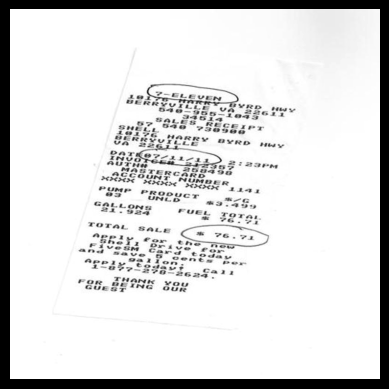

{
  "merchant_name": "7-ELEVEN",
  "address": "Berryville Byrd Hwy",
  "phone_number": "540-955-2583",
  "transaction_type": "SALES RECEIPT",
  "date": "06/24/2011",
  "time": "02:39PM",
  "invoice_number": "062411 2839561",
  "register": "5",
  "cashier": "SMITH",
  "item": "Shell 846 Harry Byrd Hwy",
  "account_number": "XXXXXXXXXXXX4986",
  "pump": "03",
  "product": "UNLDCT",
  "price_per_gallon": "3.459",
  "volume": "21.924",
  "fuel_total": "75.91",
  "total_sale": {
    "currency": "USD",
    "amount": 76.71
  },
  "payment_type": "MasterCard",
  "approval_code": "029847"
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  common-gas-receipt-writer-supports-for-usa-east-canada-uk
Image sahpe: (434, 226, 4)


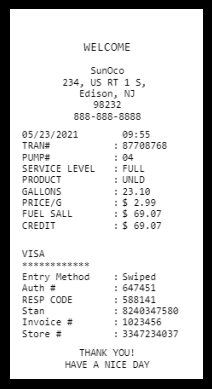

{
  "merchant_name": "SunOCO",
  "merchant_address": "234, US RT 1 S, Edison, NJ",
  "merchant_zip": "98232",
  "merchant_phone": "888-888-8888",
  "transaction_date": "05/23/2021",
  "transaction_time": "09:55",
  "transaction_id": "877068768",
  "pump_number": "04",
  "service_level": "FULL",
  "product": "UNLD",
  "volume_gallons": "23.10",
  "price_per_gallon": "2.99",
  "currency_code": "USD",
  "fuel_sale_total": "69.07",
  "payment_type": "CREDIT",
  "card_type": "VISA",
  "entry_method": "Swiped",
  "authorization_number": "647451",
  "response_code": "583141",
  "stan": "8240345780",
  "invoice_number": "1023456",
  "store_number": "3347234037",
  "net_amount_paid": "69.07"
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  common-gas-receipt-writer-supports-for-usa-west-canada-uk
Image sahpe: (800, 800)


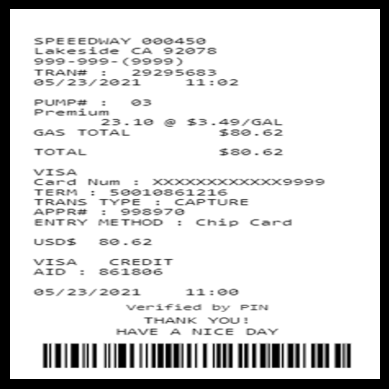

{
  "merchant_name": "SPEEDWAY 000450",
  "merchant_address": "Lakeside CA 92078",
  "merchant_phone": "999-999-(9999)",
  "transaction_number": "29295683",
  "date": "05/23/2021",
  "time": "11:02",
  "items": [
    {
      "item": "Premium Gas",
      "quantity": "23.10",
      "unit_price": "3.49",
      "total_price": "80.62"
    }
  ],
  "sub_total": "80.62",
  "total": "80.62",
  "currency": "USD",
  "payment_type": "VISA",
  "card_number": "XXXXXXXXXXXX9999",
  "terminal_number": "580128361216",
  "transaction_type": "CAPTURE",
  "approval_number": "998970",
  "entry_method": "Chip Card",
  "net_amount_paid": "80.62"
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  D-dlWMAX4AAD4u5
Image sahpe: (800, 800)


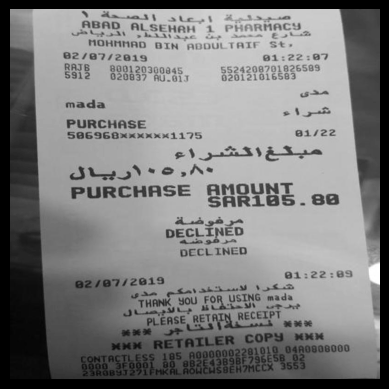

{
  "Merchant": "ABAD ALSEHAH 1 PHARMACY",
  "Address": "MOHMAD BIN ABDULATIF St",
  "Date": "07/02/2019",
  "Time": "01:22:07",
  "Terminal": "5912",
  "Card Type": "mada",
  "Card Number": "586956XXXXXX1175",
  "Transaction Type": "Purchase",
  "Purchase Amount": "SAR105.80",
  "Currency": "SAR",
  "Status": "Declined",
  "Net Amount Paid": "SAR0.00"
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  e12f2265fa4d54e44c2901db0f6b3dde
Image sahpe: (644, 370, 3)


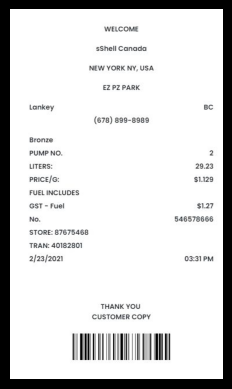

{
  "merchant_name": "Shell Canada",
  "merchant_address": "NEW YORK NY, USA",
  "merchant_phone": "(678) 899-8989",
  "transaction_type": "Bronze",
  "pump_number": "2",
  "fuel_volume_liters": "29.23",
  "price_per_liter_currency": "CAD",
  "price_per_liter": "1.129",
  "gst_currency": "CAD",
  "gst": "1.27",
  "total_amount_currency": "CAD",
  "total_amount": "33.96",
  "store_number": "87675468",
  "transaction_number": "40182801",
  "date": "02/23/2021",
  "time": "03:31 PM"
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  FI_receipt_creditcard-gas
Image sahpe: (396, 225, 3)


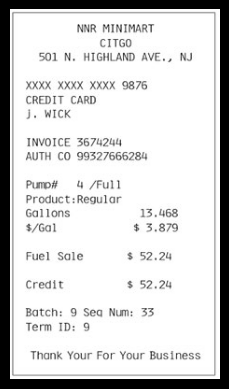

{
  "store_name": "NNR MINIMART CITGO",
  "store_address": "501 N. HIGHLAND AVE., NJ",
  "credit_card_number": "XXXX XXXX XXXX 9876",
  "cardholder_name": "J. WICK",
  "invoice_number": "3674244",
  "authorization_code": "99327666284",
  "pump_number": "4",
  "product_type": "Regular",
  "gallons": "13.468",
  "price_per_gallon": "3.879",
  "currency_code": "USD",
  "total_fuel_sale": "52.24",
  "total_amount_credited": "52.24",
  "batch_number": "9",
  "sequence_number": "33",
  "terminal_id": "9",
  "net_amount_paid": "0.00",
  "date": "Unknown"
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  g3GML
Image sahpe: (1101, 633, 3)


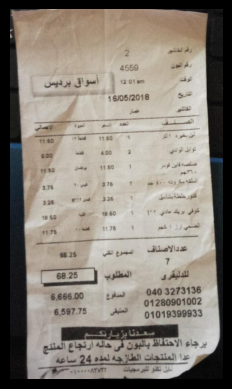

{
  "receipt_number": "4569",
  "date": "05/16/2018",
  "time": "12:01 am",
  "items": [
    {
      "name": "Unknown",
      "quantity": 1,
      "unit_price": 11.50,
      "total_price": 11.50
    },
    {
      "name": "Unknown",
      "quantity": 2,
      "unit_price": 4.00,
      "total_price": 8.00
    },
    {
      "name": "Unknown",
      "quantity": 1,
      "unit_price": 11.50,
      "total_price": 11.50
    },
    {
      "name": "Unknown",
      "quantity": 1,
      "unit_price": 3.76,
      "total_price": 3.76
    },
    {
      "name": "Unknown",
      "quantity": 1,
      "unit_price": 3.26,
      "total_price": 3.26
    },
    {
      "name": "Unknown",
      "quantity": 1,
      "unit_price": 18.50,
      "total_price": 18.50
    },
    {
      "name": "Unknown",
      "quantity": 1,
      "unit_price": 11.76,
      "total_price": 11.76
    }
  ],
  "sub_total": 68.25,
  "total_due": 68.25,
  "currency": "Unknown",
  "payments": [
    {
      "method": "Unknown",
    

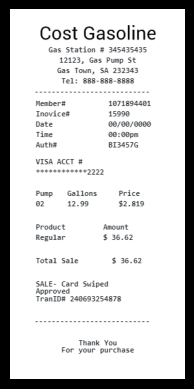

{
  "merchant_name": "Cost Gasoline",
  "station_id": "345435435",
  "address": "12123, Gas Pump St, Gas Town, SA",
  "telephone": "888-888-8888",
  "member_id": "1071894401",
  "invoice_number": "15990",
  "date": "00/00/0000",
  "time": "00:00pm",
  "auth_number": "BI3457G",
  "visa_account_number_masked": "**** **** **** 2222",
  "pump_number": "02",
  "fuel_quantity_gallons": "12.99",
  "fuel_price_per_gallon": "2.819",
  "currency_code": "USD",
  "product_type": "Regular",
  "subtotal_amount": "36.62",
  "total_amount": "36.62",
  "payment_type": "Visa",
  "transaction_approved": true,
  "transaction_id": "240693254878",
  "net_amount_paid": "36.62"
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  gas-fuel-receipt-sample (1)
Image sahpe: (997, 600, 3)


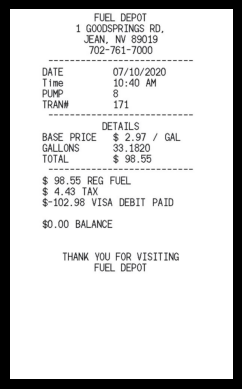

{
  "merchant_name": "FUEL DEPOT",
  "merchant_address": "1 GOODSPPRINGS RD, JEAN, NV 89019",
  "merchant_phone": "702-761-7000",
  "date": "07/10/2020",
  "time": "10:40 AM",
  "pump": "8",
  "transaction_number": "171",
  "details": {
    "base_price_per_gallon": "2.97",
    "volume_gallons": "33.1820",
    "subtotal": "98.55",
    "tax": "4.43",
    "total_amount": "98.55",
    "payment_type": "VISA DEBIT",
    "amount_paid": "102.98"
  },
  "currency": "USD",
  "balance": "0.00",
  "net_amount_paid": "98.55"
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  gas-fuel-receipt-sample
Image sahpe: (997, 600, 3)


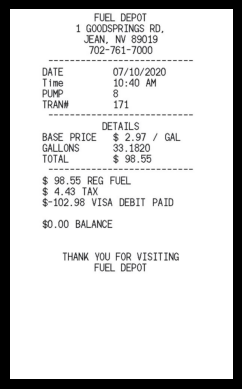

{
  "merchant_name": "FUEL DEPOT",
  "merchant_address": "1 GOODSPPRINGS RD, JEAN, NV 89019",
  "merchant_phone": "702-761-7000",
  "date": "07/10/2020",
  "time": "10:40 AM",
  "pump": "8",
  "transaction_number": "171",
  "details": {
    "base_price_per_gallon": "2.97",
    "gallons": "33.1820",
    "total_fuel_cost": "98.55",
    "currency_code": "USD"
  },
  "subtotal": "98.55",
  "tax": "4.43",
  "total_paid": "102.98",
  "payment_type": "VISA DEBIT",
  "balance": "0.00"
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  gas-fuel-receipt-smaller
Image sahpe: (400, 240, 3)


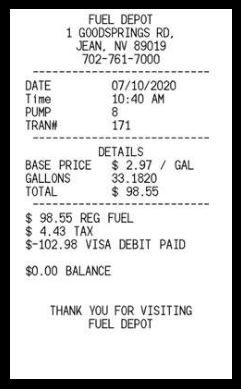

{
  "merchant_name": "FUEL DEPOT",
  "merchant_address": "1 GOODS PRINGS RD, JEAN, NV 89019",
  "merchant_phone": "702-761-7000",
  "date": "07/10/2020",
  "time": "10:40 AM",
  "pump": "8",
  "transaction_number": "171",
  "details": {
    "base_price_per_gallon": "2.97",
    "volume_in_gallons": "33.1820",
    "subtotal": "98.55",
    "tax": "4.43",
    "total_amount": "102.98"
  },
  "payment_method": "VISA DEBIT",
  "amount_paid": "102.98",
  "currency": "USD",
  "balance": "0.00"
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  GasFuelReceipt3
Image sahpe: (1361, 819, 3)


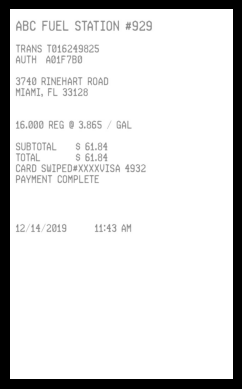

{
  "merchant_name": "ABC FUEL STATION #929",
  "transaction_id": "T016249825",
  "authorization_code": "A01F7B0",
  "address": "3740 RINEHART ROAD, MIAMI, FL 33128",
  "fuel_quantity": "16.000",
  "fuel_price_per_gallon": "3.865",
  "currency_code": "USD",
  "subtotal": "61.84",
  "total": "61.84",
  "payment_method": "VISA",
  "card_number": "XXXXXXX4932",
  "payment_status": "COMPLETE",
  "date": "12/14/2019",
  "time": "11:43 AM"
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  GasReceipt_sm
Image sahpe: (800, 800)


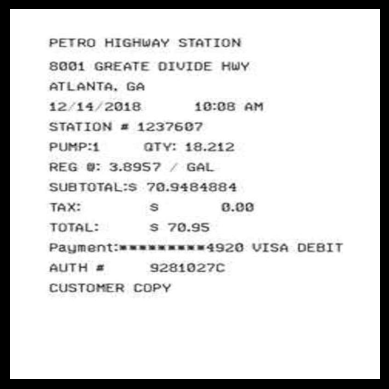

{
  "merchant": "PETRO HIGHWAY STATION",
  "address": "8001 GREATE DIVIDE HWY",
  "city": "ATLANTA",
  "state": "GA",
  "date": "12/14/2018",
  "time": "10:08 AM",
  "station_number": "1237607",
  "pump_number": "1",
  "quantity_gallons": "18.212",
  "price_per_gallon_usd": "3.8957",
  "subtotal_usd": "70.94848",
  "tax_usd": "0.00",
  "total_usd": "70.95",
  "payment_type": "VISA DEBIT",
  "authorization_number": "9281027C",
  "currency_code": "USD",
  "customer_copy": true
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  images (1)
Image sahpe: (225, 225, 3)


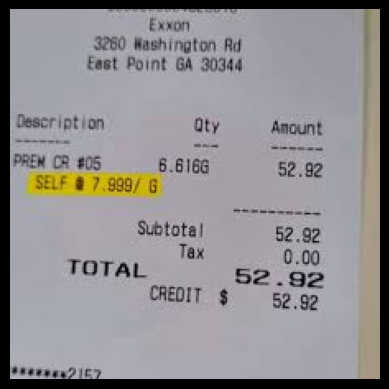

{
  "merchant_name": "Exxon",
  "merchant_address": "3260 Washington Rd, East Point GA 30344",
  "items": [
    {
      "description": "PREM CR #05",
      "quantity": "6.616G",
      "unit_price": "7.999/G",
      "amount": "52.92"
    }
  ],
  "subtotal": "52.92",
  "tax": "0.00",
  "total": "52.92",
  "currency": "USD",
  "payment_type": "CREDIT",
  "amount_paid": "52.92",
  "date": "Unknown",
  "reimbursement": "0.00",
  "net_amount_paid": "52.92"
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  images (2)
Image sahpe: (259, 194, 3)


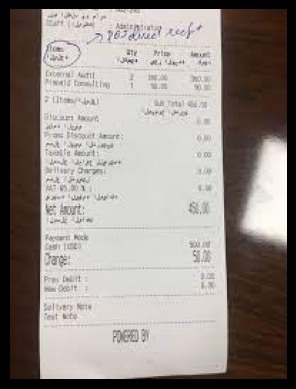

{
  "Merchant": "Unknown",
  "Transaction Date": "Unknown",
  "Items": [
    {
      "Description": "Baseball Adult",
      "Quantity": "1",
      "Unit Price": "100.00",
      "Amount": "100.00"
    },
    {
      "Description": "Baseball Youth",
      "Quantity": "1",
      "Unit Price": "150.00",
      "Amount": "150.00"
    },
    {
      "Description": "Mentoring Counseling",
      "Quantity": "1",
      "Unit Price": "90.00",
      "Amount": "90.00"
    }
  ],
  "Subtotal": "340.00",
  "Discount Amount": "Unknown",
  "Tax Amount": "5.00",
  "Total Amount": "345.00",
  "Reimbursement": "Unknown",
  "Net Amount Paid": "345.00",
  "Currency": "Unknown",
  "Payment Mode": "Cash",
  "Amount Tendered": "500.00",
  "Change": "155.00"
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  images
Image sahpe: (293, 172, 3)


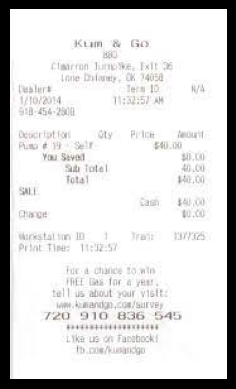

{
  "Store Name": "Kum & Go",
  "Store Address": "810 Gap Road, Cimarron Pointe, Exit 28",
  "City": "Cimarron Pointe",
  "State": "OK",
  "Zip Code": "74058",
  "Telephone": "918-454-2501",
  "Date": "10/10/2014",
  "Time": "11:32:57 AM",
  "Transaction ID": "Unknown",
  "Items": [
    {
      "Description": "Pump #11",
      "Quantity": "11.759",
      "Unit Price": "3.459",
      "Amount": "40.70"
    }
  ],
  "Subtotal": "40.70",
  "Tax": "0.00",
  "Total": "40.70",
  "Net Amount Paid": "40.70",
  "Payment Type": "Cash",
  "Change Given": "9.30",
  "Currency": "USD"
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  images
Image sahpe: (306, 165, 4)


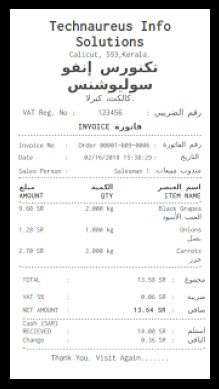

{
  "merchant_name": "Technaureus Info Solutions",
  "merchant_address": "Calicut, Kerala",
  "VAT_Reg_No": "123456",
  "Invoice_No": "012017-89-25",
  "Date": "02/16/2018",
  "Time": "15:35:29",
  "Sales_Person": "Unknown",
  "Items": [
    {
      "Item_Name": "Black Grapes",
      "Quantity": "2.000 kg",
      "Amount": "3.00 SAR"
    },
    {
      "Item_Name": "Onions",
      "Quantity": "1.000 kg",
      "Amount": "1.28 SAR"
    },
    {
      "Item_Name": "Carrots",
      "Quantity": "3.000 kg",
      "Amount": "2.70 SAR"
    }
  ],
  "Total": "6.98 SAR",
  "VAT_5%": "0.35 SAR",
  "Net_Amount": "7.33 SAR",
  "Payment_Method": "CASH",
  "Amount_Received": "10.00 SAR",
  "Change": "2.67 SAR",
  "Currency": "SAR"
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  image_1
Image sahpe: (337, 150, 3)


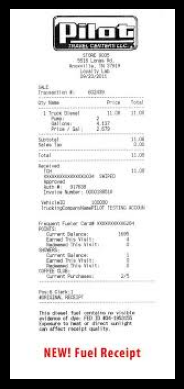

{
  "store_name": "Pilot",
  "store_address": "2551 41st Ave",
  "store_phone_number": "952-835-1565",
  "transaction_id": "600259",
  "date": "02/07/2003",
  "items": [
    {
      "description": "1 TUCK 323309",
      "quantity": "1",
      "unit_price": "12.00",
      "total_price": "12.00"
    }
  ],
  "sub_total": "12.00",
  "savings": "0.00",
  "tax": "0.63",
  "total": "12.63",
  "payment_method": "Credit Card",
  "credit_card_number": "XXXXXXXXXXXX6494",
  "approval": "217590",
  "reimbursement": "Unknown",
  "net_amount_paid": "12.63",
  "currency": "USD"
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  mZxoYBWvv4rg3C1b
Image sahpe: (800, 800)


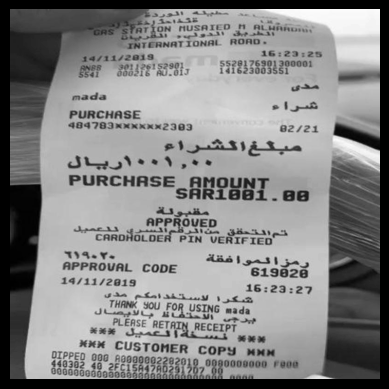

{
  "merchant_name": "GAS STATION NUSRIED H ALWHAIBI",
  "merchant_address": "INTERNATIONAL ROAD",
  "date": "11/14/2019",
  "time": "16:23:25",
  "transaction_type": "PURCHASE",
  "card_number_masked": "484783XXXXXX2383",
  "currency": "SAR",
  "purchase_amount": 1801.08,
  "approval_status": "APPROVED",
  "cardholder_verification_method": "CARDHOLDER PIN VERIFIED",
  "approval_code": "619028"
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  photo7jpg
Image sahpe: (450, 450, 3)


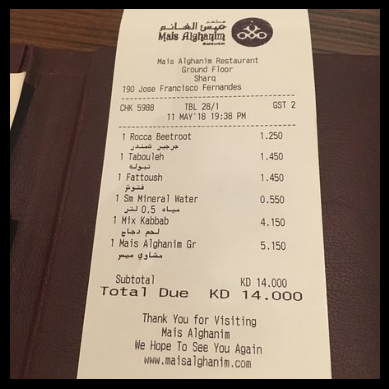

{
  "restaurant_name": "Mais Alghanim Restaurant",
  "location": "Ground Floor Sharq",
  "server_name": "Jose Francisco Fernandes",
  "check_number": "5988",
  "table_number": "28/1",
  "guest_count": "2",
  "date": "05/11/2018",
  "time": "19:38 PM",
  "items": [
    {
      "item_name": "Rocca Beetroot",
      "quantity": 1,
      "price_each": 1.250
    },
    {
      "item_name": "Tabouleh",
      "quantity": 1,
      "price_each": 1.450
    },
    {
      "item_name": "Fattoush",
      "quantity": 1,
      "price_each": 1.450
    },
    {
      "item_name": "Sm Mineral Water",
      "quantity": 1,
      "price_each": 0.550
    },
    {
      "item_name": "Mix Khabbab",
      "quantity": 1,
      "price_each": 4.150
    },
    {
      "item_name": "Mais Alghanim Gr",
      "quantity": 1,
      "price_each": 5.150
    }
  ],
  "subtotal": 14.000,
  "total_due": 14.000,
  "currency": "KWD",
  "net_amount_paid": 14.000,
  "reimbursement": null
}

--------------------------------------

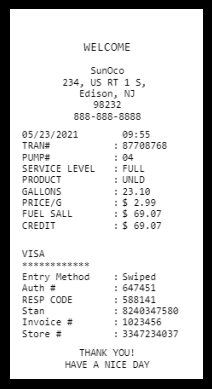

{
  "merchant_name": "SunOco",
  "merchant_address": "234, US RT 1 S, Edison, NJ",
  "merchant_postal_code": "98232",
  "merchant_phone_number": "888-888-8888",
  "date": "05/23/2021",
  "time": "09:55",
  "transaction_number": "877086768",
  "pump_number": "04",
  "service_level": "FULL",
  "product": "UNLD",
  "gallons": "23.10",
  "price_per_gallon": "2.99",
  "fuel_sale_total": "69.07",
  "payment_method": "VISA",
  "auth_number": "647451",
  "response_code": "583141",
  "stan": "8240345780",
  "invoice_number": "1023456",
  "store_number": "3347234037",
  "currency_code": "USD",
  "total_paid": "69.07"
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  receipt_1_preprocessed
Image sahpe: (800, 800)


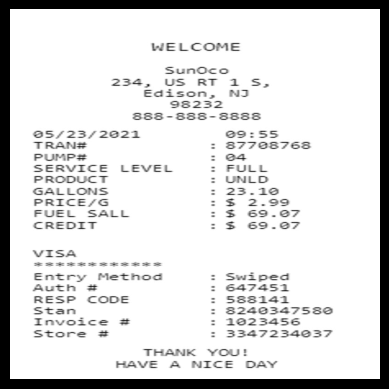

{
  "merchant_name": "SunOco",
  "merchant_address": "234, US RT 1 S, Edison, NJ",
  "merchant_zip": "98232",
  "merchant_phone": "888-888-8888",
  "transaction_date": "05/23/2021",
  "transaction_time": "09:55",
  "transaction_number": "87708768",
  "pump": "04",
  "service_level": "FULL",
  "product_type": "UNLD",
  "volume_gallons": "23.10",
  "price_per_gallon": "2.99",
  "currency_code": "USD",
  "total_sale_amount": "69.07",
  "total_paid": "69.07",
  "payment_type": "VISA",
  "authorization_number": "647451",
  "response_code": "583141",
  "stan": "8240347580",
  "invoice_number": "1023456",
  "store_number": "3347234037"
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  receipt_1_preprocessed_preprocessed
Image sahpe: (800, 800)


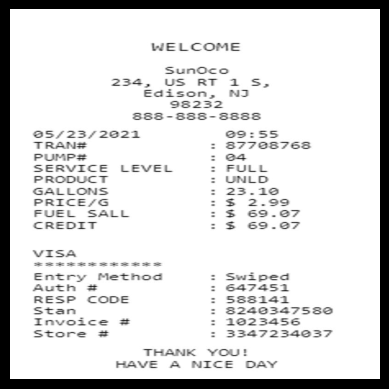

{
  "merchant": "SunOco",
  "address": "234, US RT 1 S, Edison, NJ 08837",
  "phone_number": "888-888-8888",
  "date": "05/23/2021",
  "time": "09:55",
  "transaction_number": "87708768",
  "pump": "04",
  "service_level": "FULL",
  "product": "UNLD",
  "gallons": 23.10,
  "price_per_gallon": 2.99,
  "currency_code": "USD",
  "fuel_sale": 69.07,
  "credit": 69.07,
  "net_amount_paid": 69.07,
  "payment_method": "VISA",
  "entry_method": "Swiped",
  "authorization_number": "647451",
  "response_code": "583141",
  "stan": "8240347580",
  "invoice_number": "1023456",
  "store_number": "3347234037"
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  receipt_1_preprocessed_preprocessed_preprocessed
Image sahpe: (800, 800)


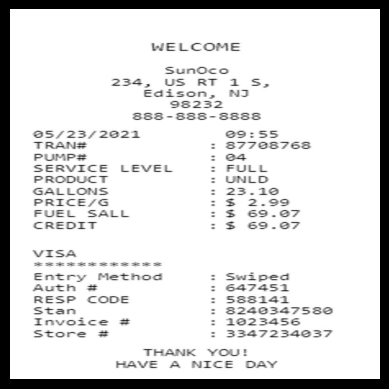

{
  "merchant": "Sunoco",
  "address": "234, US RT 1 S, Edison, NJ, 98232",
  "phone": "888-888-8888",
  "date": "05/23/2021",
  "time": "09:55",
  "transaction_number": "8770868768",
  "pump": "04",
  "service_level": "FULL",
  "product": "UNLD",
  "gallons": "23.10",
  "price_per_gallon": "2.99",
  "currency": "USD",
  "fuel_sale_total": "69.07",
  "credit_applied": "69.07",
  "net_amount_paid": "0.00",
  "payment_method": "VISA",
  "entry_method": "Swiped",
  "authorization_number": "647451",
  "response_code": "583141",
  "stan": "8240347580",
  "invoice_number": "1023456",
  "store_number": "3347234037",
  "additional_message": "THANK YOU! HAVE A NICE DAY"
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  receipt_2
Image sahpe: (800, 800)


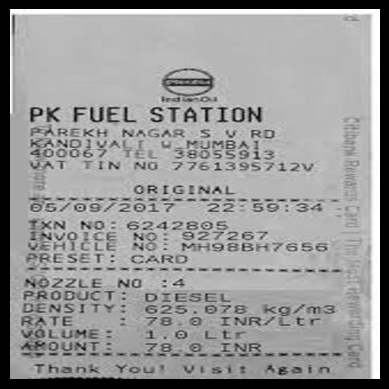

{
  "merchant_name": "PK FUEL STATION",
  "address": "PAREKH NAGAR S V RD KANDIVALI, MUMBAI",
  "phone_number": "38055913",
  "vat_tin_number": "2761395712V",
  "receipt_type": "ORIGINAL",
  "date": "05/09/2017",
  "time": "22:59:34",
  "transaction_number": "6242805",
  "invoice_number": "927267",
  "vehicle_number": "MH96BH7656",
  "payment_mode": "CARD",
  "nozzle_number": "4",
  "product": "DIESEL",
  "density": "625.0 kg/m3",
  "rate": "78.0 INR/Ltr",
  "volume": "1.0 Ltr",
  "amount": "78.0 INR",
  "currency_code": "INR",
  "net_amount_paid": "78.0"
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  receipt_3
Image sahpe: (800, 800)


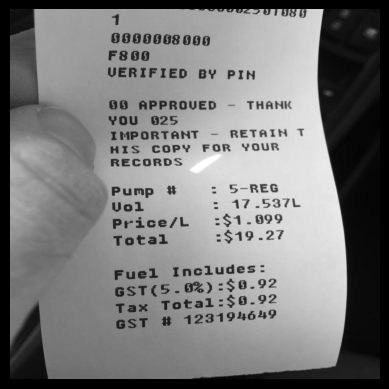

{
  "Pump_Number": "5-REG",
  "Volume": "17.537L",
  "Price_Per_Liter": "1.099",
  "Subtotal": "19.27",
  "GST_Percentage": "5",
  "GST_Amount": "0.92",
  "Total": "19.27",
  "GST_Number": "123194649",
  "Currency_Code": "Unknown",
  "Date": "Unknown",
  "Payment_Status": "APPROVED",
  "Net_Amount_Paid": "19.27"
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  receipt_4
Image sahpe: (800, 800)


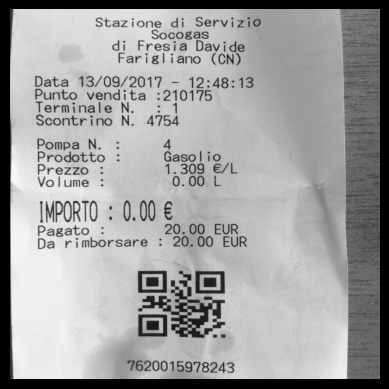

{
  "merchant_name": "Stazione di Servizio Socogas di Fresia Davide",
  "merchant_address": "Farigliano (CN)",
  "date": "09/13/2017",
  "time": "12:48:13",
  "sale_point_id": "210175",
  "terminal_number": "1",
  "receipt_number": "4754",
  "pump_number": "4",
  "product": "Gasolio",
  "price_per_unit": "1.309",
  "currency": "EUR",
  "volume": "0.00 L",
  "total_amount": "0.00",
  "amount_paid": "20.00",
  "amount_to_be_reimbursed": "20.00",
  "net_amount_paid": "0.00",
  "barcode": "7620015978243"
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  receipt_6
Image sahpe: (800, 800)


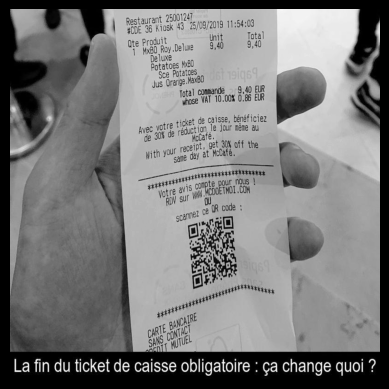

{
  "restaurant_number": "25001247",
  "order_number": "36",
  "kiosk_number": "43",
  "date": "09/25/2019",
  "time": "11:54:03",
  "items": [
    {
      "quantity": "1",
      "description": "MxBO Roy.Deluxe",
      "unit_price": "9.40",
      "total_price": "9.40"
    },
    {
      "quantity": "1",
      "description": "Potatoes MxBO",
      "unit_price": "Unknown",
      "total_price": "Unknown"
    },
    {
      "quantity": "1",
      "description": "Scie Potatoes",
      "unit_price": "Unknown",
      "total_price": "Unknown"
    },
    {
      "quantity": "1",
      "description": "Jus Orange.MxBO",
      "unit_price": "Unknown",
      "total_price": "Unknown"
    }
  ],
  "total_amount": "9.40",
  "currency": "EUR",
  "VAT": "10.00",
  "VAT_amount": "0.86",
  "payment_type": "CARTE BANCAIRE SANS CONTACT",
  "payment_institution": "CREDIT MUTUEL",
  "net_amount_paid": "Unknown",
  "reimbursement_offer": "30% off the same day at McCafé"
}

-------------------------------------

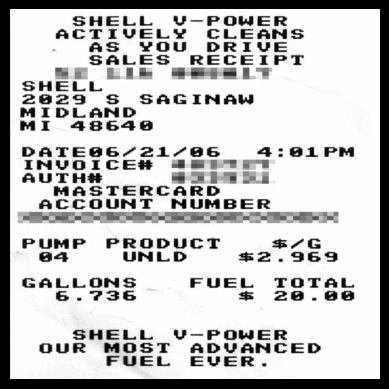

{
  "merchant_name": "SHELL",
  "merchant_address": "2029 S SAGINAW, MIDLAND, MI, 48640",
  "date": "06/21/2006",
  "time": "4:01 PM",
  "invoice_number": "Unknown",
  "authorization_number": "Unknown",
  "payment_method": "MASTERCARD",
  "account_number": "Unknown",
  "pump": "04",
  "product": "UNLD",
  "price_per_gallon": "2.969",
  "currency": "USD",
  "gallons": "6.736",
  "fuel_total": "20.00",
  "net_amount_paid": "20.00"
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  Reciept
Image sahpe: (576, 301, 3)


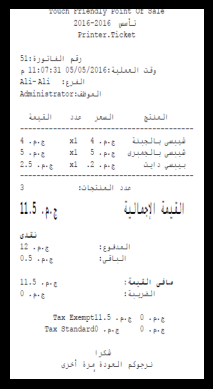

{
  "store_name": "Touch Friendly Point Of Sale",
  "date": "05/05/2016",
  "time": "11:07:31 AM",
  "cashier": "المرنزقي",
  "items": [
    {
      "item": "بيبسي ربع ليمون",
      "quantity": 1,
      "unit_price": "4.00",
      "total_price": "4.00"
    },
    {
      "item": "بيبسي ربع بردي",
      "quantity": 1,
      "unit_price": "5.00",
      "total_price": "5.00"
    },
    {
      "item": "بيبسي دايت ربع",
      "quantity": 1,
      "unit_price": "2.50",
      "total_price": "2.50"
    }
  ],
  "subtotal": "11.50",
  "discount": "0.00",
  "service_charge": "0.50",
  "tax_exempt": "0.00",
  "tax_standard": "0.00",
  "total": "11.50",
  "amount_paid": "12.00",
  "currency": "EGP",
  "change_due": "0.50",
  "net_amount_paid": "11.50"
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  reciept_10
Image sahpe: (1445, 899, 3)


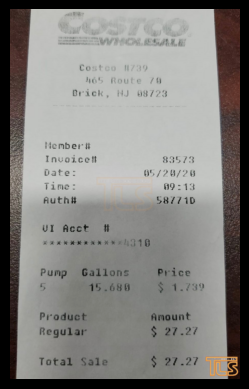

{
  "Retailer": "Costco #1730",
  "Address": "305 Route 70, Brick, NJ 08723",
  "MemberID": "Unknown",
  "Invoice": "83573",
  "Date": "05/26/2020",
  "Time": "09:13",
  "AuthNumber": "587710",
  "CardNumberEnding": "4318",
  "PumpNumber": "5",
  "FuelType": "Regular",
  "Gallons": "15.680",
  "PricePerGallon": "1.739",
  "Currency": "USD",
  "Subtotal": "27.27",
  "TotalSale": "27.27"
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  reciept_10_preprocessed
Image sahpe: (800, 800)


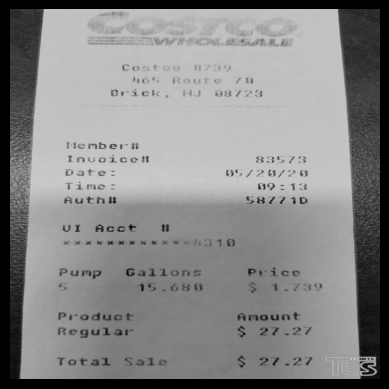

{
  "store_name": "Costco",
  "store_id": "1739",
  "address": "305 Route 70, Brick, NJ 08723",
  "member_id": "Unknown",
  "invoice_number": "83573",
  "date": "05/26/2020",
  "time": "09:13",
  "auth_number": "587710",
  "account_number_masked": "************4319",
  "item_details": {
    "pump": "5",
    "gallons": "15.680",
    "price_per_gallon": "1.730"
  },
  "product": "Regular",
  "amount": "27.27",
  "total_sale": "27.27",
  "currency_code": "USD"
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  reciept_10_preprocessed_preprocessed
Image sahpe: (800, 800)


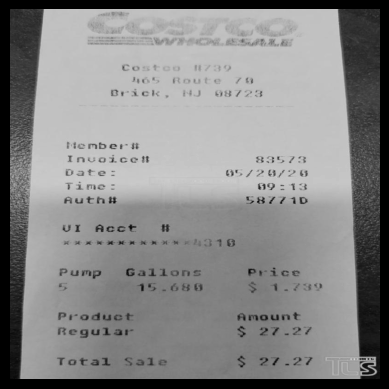

{
  "Store_Name": "Costco #1730",
  "Store_Address": "305 Route 70",
  "City": "Brick, NJ",
  "Postal_Code": "08723",
  "Member_ID": "Unknown",
  "Invoice_Number": "83573",
  "Date": "05/26/20",
  "Time": "09:13",
  "Authorization_Number": "58771D",
  "UI_Acct_Number": "*******4318",
  "Pump_Number": "5",
  "Fuel_Type": "Regular",
  "Gallons": "15.680",
  "Price_Per_Gallon": "1.739",
  "Currency_Code": "USD",
  "Subtotal": "27.27",
  "Total_Sale": "27.27"
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  reciept_11
Image sahpe: (453, 500, 3)


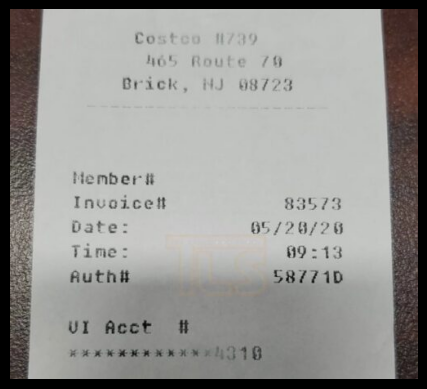

{
  "merchant_name": "Costco",
  "merchant_address": "405 Route 70, Brick, NJ 08723",
  "merchant_id": "11739",
  "member_id": "83573",
  "invoice_id": "Unknown",
  "date": "05/26/2020",
  "time": "09:13",
  "auth_number": "58771D",
  "payment_method": "Visa",
  "masked_card_number": "************4319",
  "currency": "USD",
  "total_amount": "Unknown",
  "amount_paid": "Unknown",
  "net_amount_paid": "Unknown"
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  reciept_11_preprocessed
Image sahpe: (800, 800)


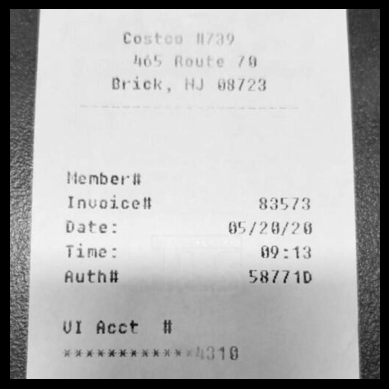

{
  "merchant_name": "Costco",
  "merchant_address": "405 Route 70, Brick, NJ 08723",
  "merchant_id": "11739",
  "member_id": "83573",
  "invoice_id": "Unknown",
  "date": "05/28/2020",
  "time": "09:13",
  "auth_number": "58771D",
  "ui_acct_number": "******4319",
  "currency_code": "USD",
  "total_amount": "Unknown",
  "amount_paid": "Unknown",
  "reimbursement": "Unknown",
  "net_amount_paid": "Unknown"
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  reciept_11_preprocessed_preprocessed
Image sahpe: (800, 800)


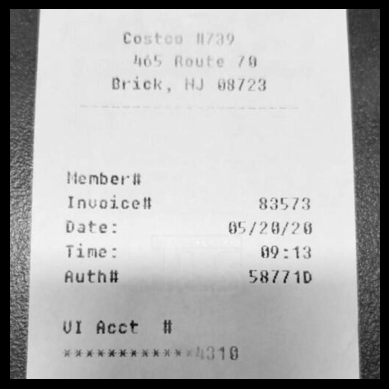

{
  "retailer": "Costco",
  "store_id": "1179",
  "address": "405 Route 70, Brick, NJ 08723",
  "member_id": "83573",
  "invoice_id": "Unknown",
  "date": "05/28/2020",
  "time": "09:13",
  "auth_number": "58771D",
  "ui_acct_number": "Unknown",
  "total": "Unknown",
  "currency": "USD",
  "payment_method": "Unknown",
  "amount_paid": "Unknown",
  "reimbursement": "Unknown",
  "net_amount_paid": "Unknown"
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  reciept_5
Image sahpe: (800, 800)


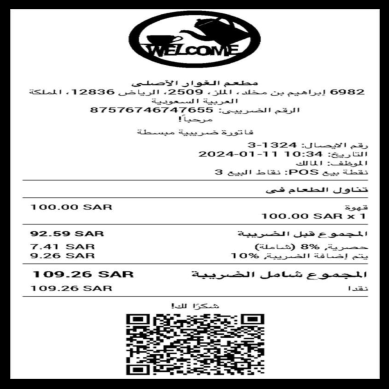

{
  "merchant_name": "Unknown",
  "transaction_number": "6982",
  "terminal_number": "12836",
  "merchant_number": "2509",
  "merchant_address": "Unknown",
  "tax_number": "8757674674655",
  "receipt_number": "1324",
  "date": "01/11/2024",
  "time": "10:34",
  "payment_method": "POS",
  "items": [
    {
      "item_description": "Unknown",
      "quantity": "1",
      "unit_price": "100.00 SAR",
      "total_price": "100.00 SAR"
    }
  ],
  "sub_total": "92.59 SAR",
  "tax_amount": "7.41 SAR",
  "total": "100.00 SAR",
  "vat_percentage": "8%",
  "vat_amount": "7.41 SAR",
  "municipality_tax_percentage": "10%",
  "municipality_tax_amount": "9.26 SAR",
  "net_amount_paid": "109.26 SAR",
  "currency": "SAR",
  "reimbursement_amount": "Unknown",
  "net_amount_after_reimbursement": "109.26 SAR"
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  reciept_7
Image sahpe: (800, 800)


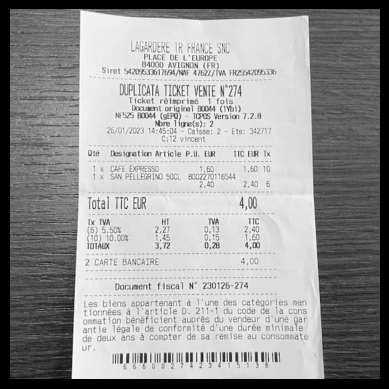

{
  "merchant_name": "LAGARDERE TR FRANCE SNC",
  "merchant_address": "PLACE DE L'EUROPE, 84000 AVIGNON (FR)",
  "merchant_siret": "542033766/NAF 4762Z/IVA FR25542093356",
  "receipt_number": "DUPLICATA TICKET VENTE N°274",
  "receipt_date": "01/26/2023",
  "receipt_time": "14:45:04",
  "cashier_name": "Vincent C.:12",
  "store_establishment": "342717",
  "items": [
    {
      "quantity": 1,
      "description": "CAFE EXPRESSO",
      "unit_price_eur": 1.60,
      "total_price_eur": 1.60,
      "tax_code": 10
    },
    {
      "quantity": 1,
      "description": "SAN PELLEGRINO 50CL",
      "unit_price_eur": 2.40,
      "total_price_eur": 2.40,
      "tax_code": 6
    }
  ],
  "total_tax_inclusive_eur": 4.00,
  "vat_summary": [
    {
      "vat_rate": "5.50%",
      "ht": 2.27,
      "vat_amount": 0.13,
      "ttc": 2.40
    },
    {
      "vat_rate": "10.00%",
      "ht": 1.45,
      "vat_amount": 0.15,
      "ttc": 1.60
    }
  ],
  "total_ht": 3.72,
  "total_vat": 0.28,
  "total_t

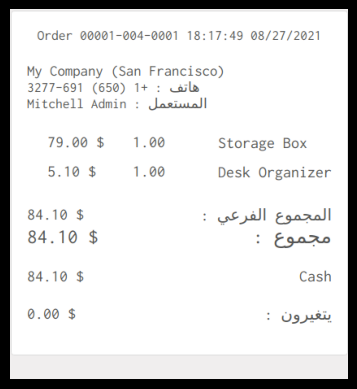

{
  "Order": "00001-004-0001",
  "Date": "08/27/2021",
  "Time": "18:17:49",
  "Company": "My Company (San Francisco)",
  "Phone": "(650) 3277-691",
  "Cashier": "Mitchell Admin",
  "Items": [
    {
      "Description": "Storage Box",
      "Quantity": 1,
      "Unit_Price": "79.00",
      "Currency": "USD"
    },
    {
      "Description": "Desk Organizer",
      "Quantity": 1,
      "Unit_Price": "5.10",
      "Currency": "USD"
    }
  ],
  "Subtotal": "84.10",
  "Currency": "USD",
  "Tax": "0.00",
  "Total": "84.10",
  "Amount_Paid": "84.10",
  "Payment_Type": "Cash",
  "Reimbursement": "0.00",
  "Net_Amount_Paid": "84.10"
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  Shell-Gas-Station-Receipt-MasterCard
Image sahpe: (1415, 915, 3)


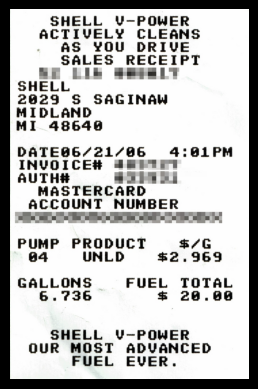

{
  "merchant_name": "SHELL",
  "merchant_address": "2029 S SAGINAW MIDLAND, MI 48640",
  "transaction_date": "06/21/1996",
  "transaction_time": "4:01 PM",
  "invoice_number": "Unknown",
  "auth_number": "Unknown",
  "account_number": "Unknown",
  "pump_number": "04",
  "product_type": "UNLD",
  "price_per_gallon": "2.969",
  "currency_code": "USD",
  "gallons_dispensed": "6.736",
  "fuel_total": "20.00"
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  Shell_Canada_fuel_receipt_template
Image sahpe: (800, 800)


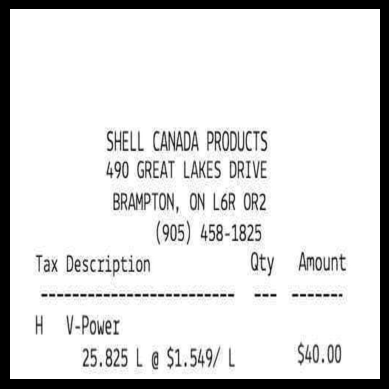

{
  "merchant_name": "SHELL CANADA PRODUCTS",
  "merchant_address": "490 GREAT LAKES DRIVE, BRAMPTON, ON L6R 0R2",
  "merchant_phone": "(905) 458-1825",
  "item_details": [
    {
      "tax_code": "H",
      "product_description": "V-Power",
      "quantity": "25.825 L",
      "unit_price": "$1.549/L",
      "currency": "CAD",
      "amount": "40.00"
    }
  ],
  "total_amount": "40.00",
  "currency": "CAD",
  "date": "Unknown",
  "payment_status": "Unknown",
  "net_amount_paid": "40.00"
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  template-shell-2-screenshot-325872
Image sahpe: (872, 325, 3)


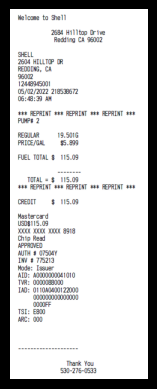

{
  "Merchant": "Shell",
  "Address": "2684 Hilltop Dr, Redding, CA 96002",
  "Phone": "530-276-0533",
  "Date": "05/02/2022",
  "Time": "02:48 AM",
  "Transaction ID": "1244489501",
  "Reference ID": "218538672",
  "Pump Number": "2",
  "Fuel Type": "Regular",
  "Volume": "19.501G",
  "Price per Gallon": "USD5.899",
  "Fuel Total": "USD115.09",
  "Payment Method": "Mastercard",
  "Card Number": "XXXX XXXX XXXX 8918",
  "Approval": "Chip Read APPROVED",
  "Invoice Number": "775213",
  "Auth #": "07504Y",
  "AID": "A0000000041010",
  "TID": "00880800",
  "Tvr": "0110008000000000",
  "Tsi": "E800",
  "Arc": "000",
  "Net Amount Paid": "USD115.09"
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  thursday-january-1st-2015-bradford-united-kingdom-as-fuel-prices-continue-ED89C7
Image sahpe: (956, 1300, 3)


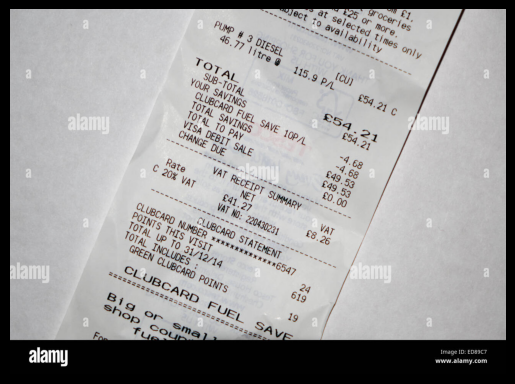

{
  "Date": "03/23/2021",
  "Time": "15:26",
  "Location": "Unknown",
  "Transaction ID": "220432321",
  "Items": [
    {
      "Description": "DIESEL",
      "Quantity": "46.7 litres",
      "Unit Price": "115.9 p/L",
      "Total Price": "£54.21"
    }
  ],
  "Subtotal": "£54.21",
  "Clubcard Savings": "Unknown",
  "Total Savings": "Unknown",
  "Total Fuel Save": "10p/L",
  "Total to Pay": "£54.21",
  "Payment Method": "VISA DEBIT",
  "Total Debit Sale": "£54.21",
  "Change Due": "£0.00",
  "VAT Receipt Summary": {
    "VAT Rate": "20%",
    "Net": "£41.17",
    "VAT": "£8.26"
  },
  "Clubcard Number": "************6547",
  "Points Earned": {
    "This Visit": "24 points",
    "Total to 31/12/14": "619 points"
  },
  "Currency": "GBP"
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  tumblr_qmeb94yP0j1y6s13co1_1280
Image sahpe: (1920, 1108, 3)


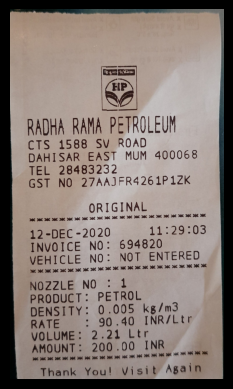

{
  "merchant_name": "RADHA RAMA PETROLEUM",
  "address": "CTS 1588 SV ROAD DAHISAR EAST MUM 400068",
  "telephone": "28483232",
  "GST_number": "27AAJFR4261P1ZK",
  "date": "12/12/2020",
  "time": "11:29:03",
  "invoice_number": "694820",
  "vehicle_number": "NOT ENTERED",
  "product": "PETROL",
  "density": "0.005 kg/m3",
  "rate": "90.40 INR/Ltr",
  "volume": "2.21 Ltr",
  "currency": "INR",
  "total_amount": 200.00
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  tumblr_qq9iczYIZV1y6s13co1_540
Image sahpe: (800, 408, 3)


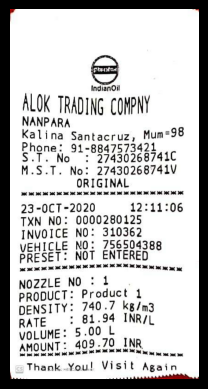

{
  "merchant_name": "ALOK TRADING COMPNY",
  "address": "NANPARA Kalina Santacruz, Mum=98",
  "phone_number": "91-8847573421",
  "tax_info": {
    "S.T. No": "ST-8847573421",
    "M.S.T. No": "27430268741C"
  },
  "date": "10/23/2020",
  "time": "12:11:06",
  "transaction_number": "0000280125",
  "invoice_number": "310362",
  "vehicle_number": "Unknown",
  "nozzle_number": "1",
  "product": "Product 1",
  "density": "740 Kg/m3",
  "rate": "81.94 INR/L",
  "volume": "5.00 L",
  "amount_paid": "409.70 INR",
  "currency_code": "INR"
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  unnamed
Image sahpe: (512, 512, 3)


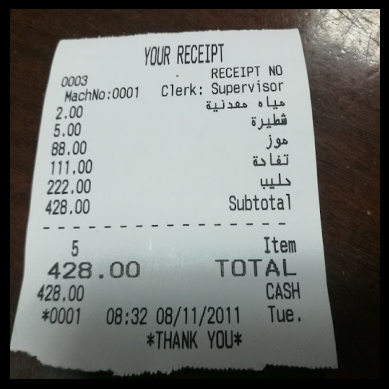

{
  "receipt_number": "0003",
  "machine_number": "0001",
  "clerk": "Supervisor",
  "items": [
    {"item_price": 2.00},
    {"item_price": 5.00},
    {"item_price": 88.00},
    {"item_price": 111.00},
    {"item_price": 222.00}
  ],
  "subtotal": 428.00,
  "total": 428.00,
  "payment_type": "CASH",
  "currency": "Unknown",
  "date": "08/11/2011",
  "time": "08:32",
  "day_of_week": "Tuesday",
  "net_amount_paid": 428.00
}

---------------------------------------------------------------------
---------------------------------------------------------------------

Item:  untitled
Image sahpe: (250, 173, 3)


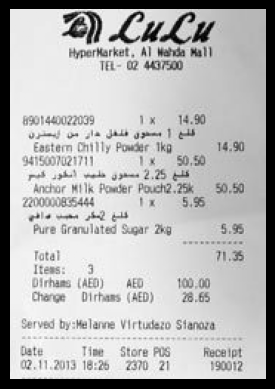

{
  "store_name": "HyperMarket, Al Wahda Mall",
  "telephone": "02 4437500",
  "items": [
    {
      "item_code": "6901440202039",
      "description": "Eastern Chilly Powder 1kg",
      "quantity": "1",
      "unit_price": "14.90",
      "total_price": "14.90"
    },
    {
      "item_code": "9415007021771",
      "description": "Anchor Milk Powder Pouch 2.25kg",
      "quantity": "1",
      "unit_price": "50.50",
      "total_price": "50.50"
    },
    {
      "item_code": "220000085444",
      "description": "Pure Granulated Sugar 2kg",
      "quantity": "1",
      "unit_price": "5.95",
      "total_price": "5.95"
    }
  ],
  "total": "71.35",
  "currency": "AED",
  "number_of_items": "3",
  "payment_given": "100.00",
  "change": "28.65",
  "cashier": "Melanne Virtudez Sianoya",
  "transaction_date": "02/11/2013",
  "transaction_time": "18:26",
  "store_id": "2370",
  "receipt_number": "190012"
}

---------------------------------------------------------------------
--------------

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

products_folder = 'reciept_images'
for image in os.listdir(products_folder):
    product_name = image.split('.')[0]
    print("Item: ", product_name)
    image_path = os.path.join(products_folder,image)
    
    # Load the image
    img = mpimg.imread(image_path)  

    # Print the image size
    # height, width, channels = img.shape
    print("Image shape: {}".format(img.shape)) 
     
    # Display the image
    plt.imshow(img, cmap='gray')
    plt.axis('off')  # Turn off axis
    plt.show()

    #Get image description
    response = analyse_image(image_path)
    print(response)
    
    print("\n---------------------------------------------------------------------")
    print("---------------------------------------------------------------------\n")